In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA

In [3]:
# path = "data/GTAV/small/00001.png"
# img = cv2.imread(path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()
# img.size * img.itemsize

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
scaling_factor = 2
crop_size = 96*scaling_factor
# large_kernel_size = 9
# small_kernel_size = 3
# n_channels = 64
# n_blocks = 16
lr_img_type = '[0, 1]' #'gta-small-norm'
hr_img_type = '[0, 1]'

batch_size = 48
epochs = 2
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_Data = GTA(train_path,'test',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=True)
test_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [6]:
# batch = next(iter(test_dataloader))
# print(len(batch))
# plt.imshow(batch[0][0].permute(1, 2, 0))
# plt.show()
# plt.imshow(batch[1][0].permute(1, 2, 0))
# plt.show()
# print(batch[0][0].shape, batch[1][0].shape)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.max_pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_conv = ConvBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.concat_conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, img_channels, initial_depth = 16, height=5):
        super(UNet, self).__init__()
        self.height = height

        # List of encoders
        self.encoders = nn.ModuleList()

        current_channels = initial_depth
        previous_channels = img_channels
        for _ in range(height):
            self.encoders.append(EncoderBlock(previous_channels, current_channels))
            previous_channels = current_channels
            current_channels *= 2

        # Bottleneck
        self.bottleneck = ConvBlock(previous_channels, current_channels)

        # List of decoders
        self.decoders = nn.ModuleList()
        for _ in range(height):
            previous_channels = current_channels
            current_channels //= 2
            self.decoders.append(DecoderBlock(previous_channels, current_channels, current_channels))

        # Final convolution layer
        self.final_conv = nn.Conv2d(initial_depth, n_classes, kernel_size=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        c = []
        for i in range(self.height):
            c_i, x = self.encoders[i](x)
            c.append(c_i)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for i in range(self.height):
            x = self.decoders[i](x, c[-(i + 1)])

        # Final output
        output = self.final_conv(x)
        # output = self.sigmoid(output)
        return output



In [8]:
torch.cuda.empty_cache()
model = UNet(n_classes=3, img_channels=3).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [9]:
checkpoint = torch.load('checkpoint_Unet.pth.tar')
# Extract the state_dict of the model and optimizer
model.load_state_dict(checkpoint['model'].state_dict())  # For the model
optimizer.load_state_dict(checkpoint['optimizer'].state_dict())       # For the optimizer

# Optionally, load the epoch or other metadata
start_epoch = checkpoint['epoch']

print(f"Resumed training from epoch {start_epoch}")

Resumed training from epoch 60


In [10]:
losses = []

In [11]:
criterion = nn.MSELoss().to(device)
start_epoch = 0

epochs = 10
for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)


EPOCH 1


Epoch 1/10:  98%|█████████▊| 52/53 [01:11<00:01,  1.03s/it, loss=0.000977]/home/deniz/.local/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/deniz/.local/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/10: 100%|██████████| 53/53 [01:11<00:00,  1.35s/it, loss=0.000977]


EPOCH 2


Epoch 2/10: 100%|██████████| 53/53 [01:15<00:00,  1.42s/it, loss=0.000975]


EPOCH 3


Epoch 3/10:  66%|██████▌   | 35/53 [00:57<00:29,  1.64s/it, loss=0.000976]


KeyboardInterrupt: 

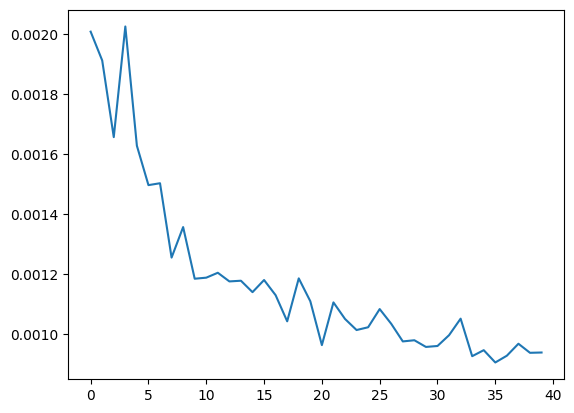

In [37]:
plt.plot(losses[20:])
plt.show()

In [34]:
len(losses)

60

torch.Size([3, 192, 192])
torch.Size([3, 192, 192])


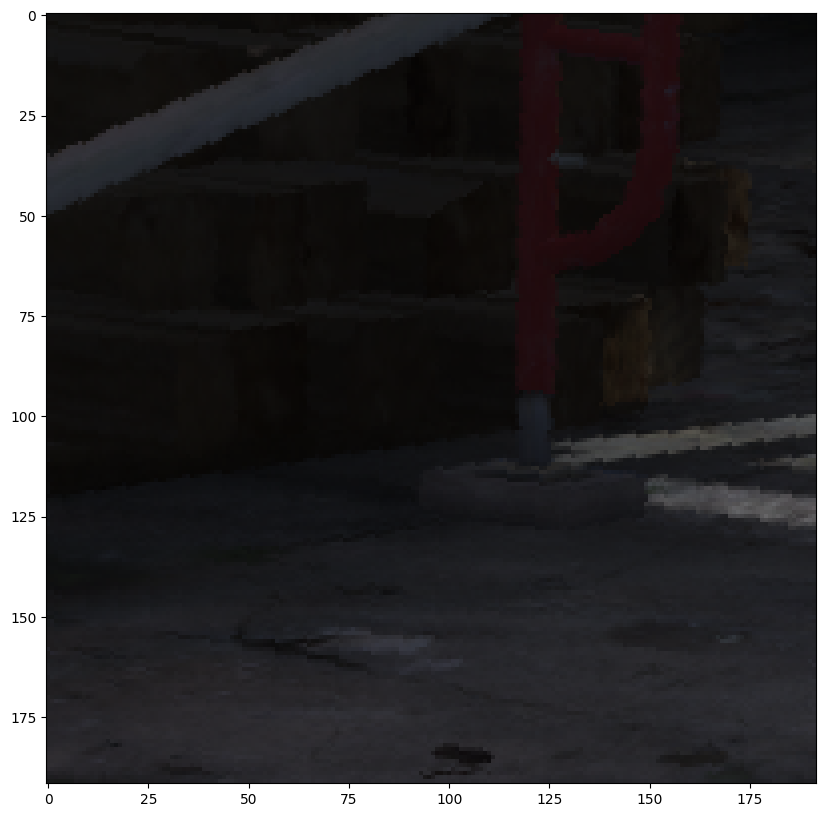

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


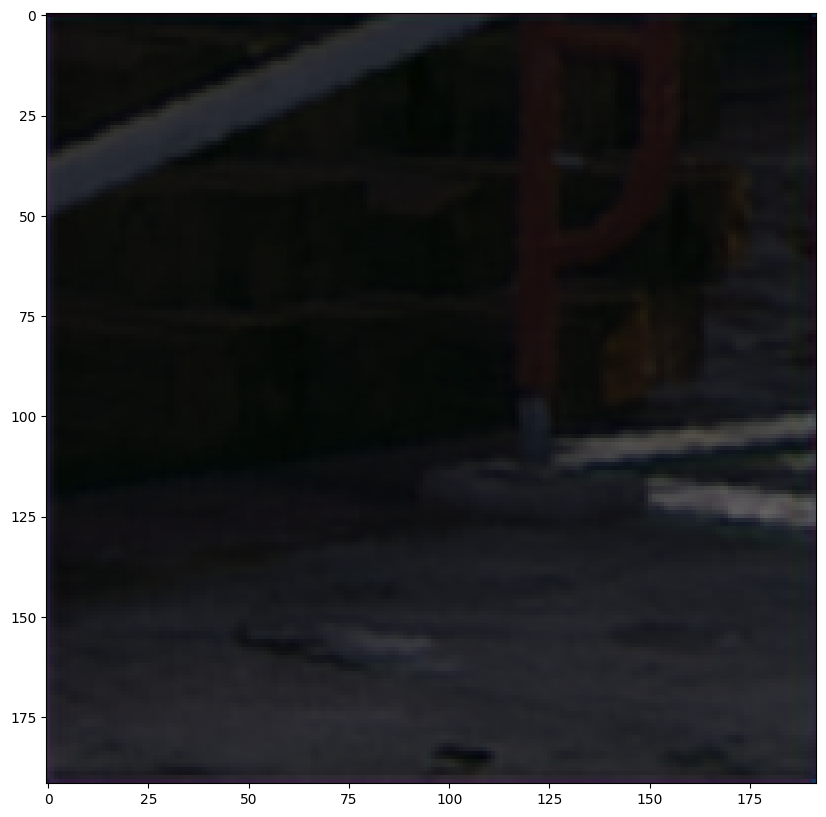

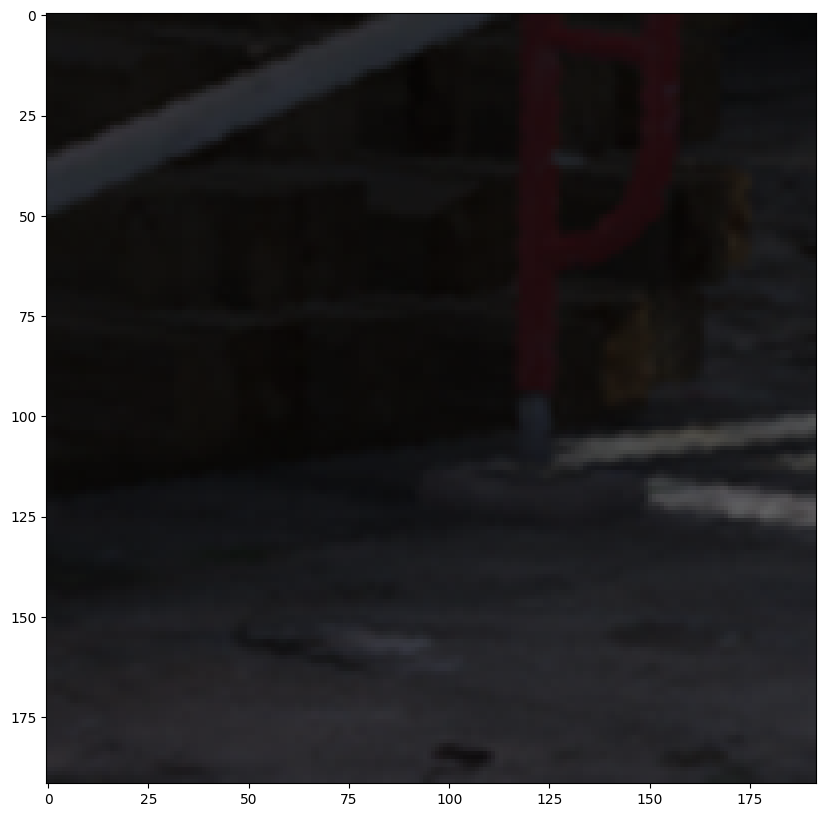

In [24]:
with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        print(lr_img.shape)
        sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        print(lr_img.shape)
        # plt.imshow(np.concatenate([sr_img, (hr_img).permute(1, 2, 0).numpy()], axis=1))
        # plt.show()
        size = (10,10)
        plt.figure(figsize=size)
        plt.imshow((hr_img).permute(1, 2, 0).numpy())
        plt.show()
        plt.figure(figsize=size)
        plt.imshow(sr_img)
        plt.show()
        plt.figure(figsize=size)
        plt.imshow((lr_img).permute(1, 2, 0).numpy())
        plt.show()
        break

In [32]:
import torchvision.transforms.functional as FT
with torch.no_grad():
    x_hr_original = training_data.get_full_image(6)

    new_width = (x_hr_original.width // 32) * 32
    new_height = (x_hr_original.height // 32) * 32
    x_hr = x_hr_original.resize((new_width, new_height),Image.BICUBIC)

    x_lr = x_hr.resize((int(x_hr.width / 2), int(x_hr.height / 2)),
                               Image.BICUBIC)
    x_lr = x_lr.resize((int(x_hr.width), int(x_hr.height)),Image.BICUBIC)

   
    
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    print(x_lr.shape)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    #x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    x_sr = np.clip(x_sr, 0, 1)
    plt.imsave('out.png',x_sr)

    plt.imsave('in.png',x_lr.to('cpu').squeeze(0).permute(1, 2, 0).numpy())
    plt.imsave('high-res.png', np.array(x_hr))

    # Save just the truck for closer inspection
    x_hr_truck = x_hr_original.crop((400, 300, 660, 474))
    new_width = (x_hr_truck.width // 64) * 64
    new_height = (x_hr_truck.height // 64) * 64
    x_hr_truck = x_hr_truck.resize((new_width, new_height),Image.BICUBIC)

    x_lr = x_hr_truck.resize((int(x_hr_truck.width / 2), int(x_hr_truck.height / 2)),
                               Image.BICUBIC)
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    #x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    x_sr = np.clip(x_sr, 0, 1)
    plt.imsave('truck-out.png',x_sr)

    plt.imsave('truck-in.png',x_lr.to('cpu').squeeze(0).permute(1, 2, 0).numpy())
    plt.imsave('truck-high-res.png', np.array(x_hr_truck))

    # Save just the sign for closer inspection
    x_hr_sign = x_hr_original.crop((1720, 172, 1872, 240))
    new_width = (x_hr_sign.width // 32) * 32
    new_height = (x_hr_sign.height // 32) * 32
    x_hr_sign = x_hr_sign.resize((new_width, new_height),Image.BICUBIC)
    x_lr = x_hr_sign.resize((int(x_hr_sign.width / 2), int(x_hr_sign.height / 2)),
                               Image.BICUBIC)
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    #x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    x_sr = np.clip(x_sr, 0, 1)
    plt.imsave('sign-out.png',x_sr)

    plt.imsave('sign-in.png',x_lr.to('cpu').squeeze(0).permute(1, 2, 0).numpy())
    plt.imsave('sign-high-res.png', np.array(x_hr_sign))

torch.Size([1, 3, 1024, 1888])


In [38]:
3/0
torch.save({'epoch': len(losses),
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_Unet.pth.tar')